# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [3]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [4]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10455 / 11441 MB available


In [9]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][a] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

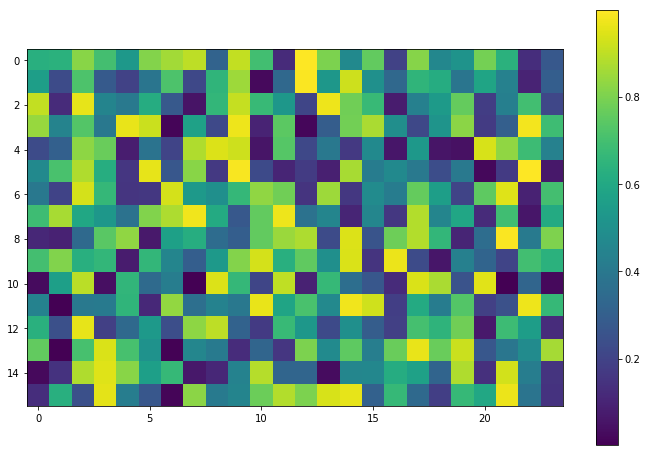

In [13]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [14]:
print(a.shape)

(16, 24)


In [15]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [16]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [25]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) # now domain size is [x, y]
block_size = (8, 4, 1) #These need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [29]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.331604  , 0.6833059 , 1.6361595 , 0.7412193 , 1.4187589 ,
        1.2796102 , 0.92713153, 1.1710606 , 0.79203516, 1.1588718 ,
        1.0635885 , 0.5272921 , 1.7265787 , 0.8416593 , 0.86052036,
        1.4796038 , 0.70685595, 1.2922579 , 0.718171  , 1.3839214 ,
        1.4730489 , 1.3551692 , 0.2448189 , 1.1604248 ],
       [1.5403695 , 0.5332219 , 1.5351458 , 1.0697228 , 0.23758158,
        0.835173  , 1.0787506 , 0.37792388, 1.0672488 , 1.19579   ,
        0.48136014, 0.6498078 , 1.7323378 , 0.5584149 , 1.6462158 ,
        1.2277045 , 1.2710173 , 1.0891317 , 1.173923  , 0.9569369 ,
        0.73041314, 1.2151816 , 0.35225147, 0.9852752 ],
       [0.9849657 , 1.0954164 , 1.7332226 , 1.2962323 , 1.1550025 ,
        1.3515822 , 0.86592674, 0.87610614, 1.5513527 , 1.2079406 ,
        1.6343534 , 1.2156935 , 1.007573  , 1.176581  , 1.5586231 ,
        1.3250573 , 0.31843144, 1.3348824 , 1.3106498 , 1.2382176 ,
        0.3173633 , 0.9997216 , 1.2932045 , 0.6015496 ],
       [1.209

In [30]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.331604   0.6833059  1.6361595  0.7412193  1.4187589  1.2796102
  0.92713153 1.1710606  0.79203516 1.1588718  1.0635885  0.5272921
  1.7265787  0.8416593  0.86052036 1.4796038  0.70685595 1.2922579
  0.718171   1.3839214  1.4730489  1.3551692  0.2448189  1.1604248 ]
 [1.5403695  0.5332219  1.5351458  1.0697228  0.23758158 0.835173
  1.0787506  0.37792388 1.0672488  1.19579    0.48136014 0.6498078
  1.7323378  0.5584149  1.6462158  1.2277045  1.2710173  1.0891317
  1.173923   0.9569369  0.73041314 1.2151816  0.35225147 0.9852752 ]
 [0.9849657  1.0954164  1.7332226  1.2962323  1.1550025  1.3515822
  0.86592674 0.87610614 1.5513527  1.2079406  1.6343534  1.2156935
  1.007573   1.176581   1.5586231  1.3250573  0.31843144 1.3348824
  1.3106498  1.2382176  0.3173633  0.9997216  1.2932045  0.6015496 ]
 [1.2099931  1.142343   0.7815242  0.97876096 1.2704113  1.0435803
  0.14882839 0.9634764  0.77041924 1.7484229  0.83989435 0.81586283
  0.90195084 0.97498876 0.91527796 1.4168038  0.5

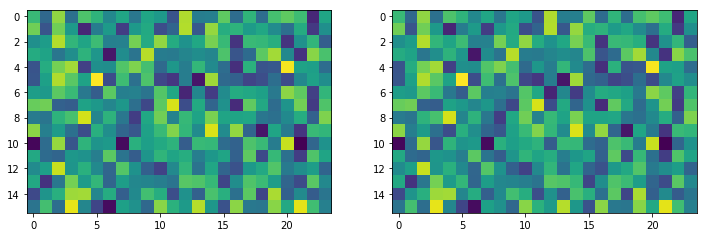

In [31]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)